# 토마토 가격 예측

- 토마토마(김준회, 연제호, 정다영, 추영은)
- 발표일 : 2020년 3월 19일

# 1. 서론

### 1) 분석 배경

최근 몇년간 미세먼지에 대한 관심이 높아졌다. 미세먼지는 황사처럼 하늘을 부옇게 만들고 먼거리까지 이동한다는 점에서 매우 비슷하나 주로 봄에 영향을 주는 황사와 달리 일년 내내 영향을 주며 발생 과정과 특성 역시 많은 차이가 있다. 미세먼지는 가정의 난방과 취사, 자동차 운행, 공장에서의 화석연료의 사용, 산불 및 화전 경작 등으로 발생한 인위적인 입자로 크기는 황사보다 훨씬 작은 2㎛(마이크로미터) 이하이다. 지름 10㎛ 이하의 먼지는 체내에 흡수되어 다양한 질병의 원인이 된다는 내용이 널리 알려져 마스크가 생활화되었다. 

미세먼지는 인체 뿐만 아니라 농가에도 피해를 주고 있다. 비닐하우스에서 재배하는 식물의 경우 농가에서 비닐하우스 위에 내려앉은 미세먼지를 자주 걷어내기 어렵고 유리온실도 마찬가지로 미세먼지으로 인한 투광량이 떨어져 작물의 상품성과 생산성이 떨어진다는 것이다. 특히, 토마토의 경우 노지보다는 하우스 시설에서 재배하고 있고 저장성이 약한데다가 국내 생산 의존도가 높아 어느 농산물 보다 가격 변동이 크다고 한다.

### 2) 분석 목적

미세먼지에 따른 일조량의 변화와 토마토 생산량 및 가격을 예측하고자 한다.

## 2. 데이터 준비

### 1) 활용 데이터

 데이터 | 사용 변수 | 시점 | 출처 | 파일 형식
:---:|:-------:|:---:|:---:|:--------:
토마토 일별 품목별 도.소매가격정보 | 품목명, 품종명,	시군구,	마켓명,	연도,	날짜,	가격 | 일 | [농산물유통정보](https://kdx.kr/kamis/periodProductList) | csv
대기오염 최종확정자료  | 지역, 측정소코드, 측정소명, 측정일시, SO2, CO, O3, NO2, PM10 | 시간 | [AirKorea](https://www.airkorea.or.kr/web/last_amb_hour_data?pMENU_NO=123) | xlsx
종관기상관측(ASOS) | 지점명,	일시,	합계 일조시간 | 일 | [기상청 기상자료개방포털](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36) | csv

#### 종관기상관측(ASOS) 변수 설명

 - 합계 일조시간 : 태양 광선이 구름이나 안개로 가려지지 않고 땅 위를 비친 시간

#### 대기오염 최종확정자료

 - SO2 : 아황산가스
 - CO : 이산화탄소
 - O3 : 오존
 - NO2 : 이산화질소
 - PM10 : 미세먼지

## 3. 데이터 가공

#### 필요한 라이브러리 불러오기

In [1]:
import pandas as pd # 데이터 프레임
import numpy as np # 계산
import re # 정규표현식

import warnings
warnings.filterwarnings('ignore') # warning 메시지 제거

import seaborn as sns # 시각화
import graphviz # 시각화

#### 시각화를 위한 한글 폰트 설정하기

In [2]:
import matplotlib.pyplot as plt

# 한글 폰트 지정
plt.rc('font', family='AppleGothic') # 맥
# plt.rc('font', family='Malgun Gothic') # 윈도우

# 마이너스 값 깨지는 현상 해결
plt.rc('axes', unicode_minus=False)

# 레티나 디스플레이 설정
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

#### 작업 경로 지정

In [3]:
import os # wd 변경

# os로 작업 경로 지정
# os.chdir('D:/5 Project/GitHub/CollaborationWork/jyeon94/Learning_Spoons_Second_Project/data/')
os.chdir('/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data')

### 1) 대기 오염 데이터

In [4]:
# 빈 리스트 생성하기
# list_Data = []

In [5]:
# 컬럼 위치를 변경하기 위해 reColindex 함수 생성

def reColindex(df, ori, fix):
    cols = df.columns.tolist()
    tmp = cols[fix - 1]
    del cols[fix - 1]
    cols.insert(ori - 1, tmp)
    return df[cols]

In [6]:
# 필요없는 컬럼 삭제 / 시간별을 날짜별로 처리 / 그룹화 하여 평균 처리하기 위한 DataModify 함수 생성

# def DataModify(list_D):
#     if "망" in list_D[len(list_Data) - 1].columns.tolist() :
#         list_D[len(list_Data) - 1] = list_D[len(list_Data) - 1].drop(['망'], axis = 1) 
#     list_D[-1]["측정일시"] = list_Data[-1]["측정일시"].astype(str).str.slice(start = 0, stop = -2)
#     list_D[-1] = list_D[-1].groupby(["지역", "측정소코드", "측정소명", "측정일시"]).mean().reset_index()

In [7]:
# 파일 경로 변수에 저장
# str_Root = "D:/5 Project/GitHub/CollaborationWork/jyeon94/Learning_Spoons_Second_Project/"
# str_Root = '/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data'

* **2013년 데이터 중 이상데이터 -999 값이 존재**
→ 측정되지 않은 것으로 추측, 0으로 변경

In [8]:
# 2013년 데이터 전처리

# str_File = str_Root + "air/2013년0X분기"
# for i in range(4) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     list_Data[i] = reColindex(list_Data[i], 3, 2)
#     list_Data[i]['PM25'] = np.nan
#     list_Data[i] = reColindex(list_Data[i], 11, 10)

#     # 안됨. 이유를 아직 모르겠음.
#     #    for j in range(6) :
#     #        list_Data[i].iloc[list_Data[i][j + 4] == -999, j + 4] = 0
#     #        print(j + 4, " ", "컬럼 수정 완료" )

#     # 그래서 루프를 돌릴 수 없어서 하드 코딩 처리함.
#     list_Data[i].loc[list_Data[i]["SO2"] == -999, "SO2"] = 0
#     list_Data[i].loc[list_Data[i]["CO"] == -999, "CO"] = 0
#     list_Data[i].loc[list_Data[i]["O3"] == -999, "O3"] = 0
#     list_Data[i].loc[list_Data[i]["NO2"] == -999, "NO2"] = 0
#     list_Data[i].loc[list_Data[i]["PM10"] == -999, "PM10"] = 0    
#     list_Data[i].loc[list_Data[i]["PM25"] == -999, "PM25"] = 0        
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [9]:
# 제대로 처리 되었는지 테스트
# list_Data[3].loc[list_Data[3]["SO2"] < 0, "SO2"]
# 비어있는 시리즈가 나온다면 제대로 처리됨.

In [10]:
# 2014년 데이터 전처리

# str_File = str_Root + "air/2014년 X분기"
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv", encoding = 'EUC-KR'))
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [11]:
# 2015년 데이터 전처리

# str_File = str_Root + 'air/2015년X분기'
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv"))
#     DataModify(list_Data)

# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [12]:
# 2016년 데이터 전처리

# str_File = str_Root + 'air/2016년 X분기'
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv", encoding = 'EUC-KR'))
#     DataModify(list_Data)

# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [13]:
# 2017년 데이터 전처리

# str_File = str_Root + 'air/2017년 X월'
# for i in range(12) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     DataModify(list_Data)
    
# print(len(list_Data))

# list_Data[len(list_Data) - 1].head()

In [14]:
# 2018년 데이터 전처리

# str_File = str_Root + 'air/2018년 X분기'
# for i in range(4) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [15]:
# 데이터 병합
# df = pd.concat(list_Data)

In [16]:
# 날짜 데이터 타입 변경
# df["측정일시"] = pd.to_datetime(df["측정일시"])
# df.sort_values(by=["측정일시", "지역"], axis=0, ascending = True)

In [17]:
# 최종 확인
# df[df["PM10"] == 0]

In [18]:
# 용량이 크기 때문에 csv파일로 저장 후 다시 불러올 예정
# df.to_csv("/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data/날씨_시계열_데이터.csv", encoding = "CP949", index = False)

In [19]:
# 저장한 날씨 데이터를 불러와 변수 df로 저장
df = pd.read_csv('날씨_시계열_데이터.csv', encoding='euc-kr')

In [20]:
# 측정일시 컬럼의 연월일을 연도, 월일로 나누기
df['연도'] = df['측정일시'].str.split("-").str.get(0)
df['월'] = df['측정일시'].str.split("-").str.get(1)
df['일'] = df['측정일시'].str.split("-").str.get(2)

In [21]:
# 토마토 도매가격, 일조량과 컬럼명을 동일하게 하기 위해 측정일시 컬렴명을 일시로 변경
df.rename(columns={'측정일시':'일시'}, inplace=True)

In [22]:
#null값 처리를 위해 날짜 컬럼 생성
df['날짜'] = df['월'] + '-' + df['일']

#날짜별 PM25 평균을 구해서 df_mean에 담기
df_mean = df.groupby('날짜')['PM25'].mean().reset_index()

#df_mean 제대로 생성되었는지 확인
df_mean

#날짜를 키로 PM25를 value로 딕셔러니 생성
fill_na = dict(zip(df_mean['날짜'],df_mean['PM25']))

#PM25의 null값들을 dictionary value로 채움
df.loc[df['PM25'].isnull(), 'PM25'] = df['날짜'].map(fill_na)

In [23]:
# 딕셔너리 생성
dic_Sido = {"서울" : "서울특별시",
            "부산" : "부산광역시",
            "대구" : "대구광역시",
            "인천" : "인천광역시",
            "광주" : "광주광역시",
            "대전" : "대전광역시",
            "울산" : "울산광역시",
            "세종" : "세종특별시",
            "경기" : "경기도",
            "강원" : "강원도",
            "충북" : "충청북도",
            "충남" : "충청남도",
            "전북" : "전라북도",
            "전남" : "전라남도",
            "경북" : "경상북도",
            "경남" : "경상남도",
            "제주" : "제주도"}

# 지역을 쪼개서 도로 저장
df['도'] = df["지역"].str.split(" ").str.get(0)

In [24]:
# 딕셔너리 데이터를 map 함수에 사용하여 key 값과 같은 값들은 전부 value 값으로 변경
df["도"] = df["도"].map(dic_Sido)

In [25]:
df = df.drop(['지역', '측정소코드'], axis = 1)
df

,측정소명,일시,SO2,CO,O3,NO2,PM10,PM25,연도,월,일,날짜,도
0,옥천동,2013-01-01,0.009875,0.579167,0.020958,0.013125,41.333333,31.543635,2013,01,01,01-01,강원도
1,옥천동,2013-01-02,0.007125,0.479167,0.026750,0.007000,36.166667,37.602906,2013,01,02,01-02,강원도
2,옥천동,2013-01-03,0.006167,0.437500,0.024708,0.009125,26.500000,35.062375,2013,01,03,01-03,강원도
3,옥천동,2013-01-04,0.007292,0.608333,0.016833,0.019417,38.708333,37.749110,2013,01,04,01-04,강원도
4,옥천동,2013-01-05,0.007792,0.595833,0.025167,0.007667,36.250000,33.378771,2013,01,05,01-05,강원도
...,...,...,...,...,...,...,...,...,...,...,...,...,...
721266,칠금동,2018-12-27,0.003917,0.300000,0.019042,0.022417,38.458333,10.666667,2018,12,27,12-27,충청북도
721267,칠금동,2018-12-28,0.004333,0.375000,0.011667,0.027292,43.708333,15.666667,2018,12,28,12-28,충청북도
721268,칠금동,2018-12-29,0.004500,0.479167,0.011750,0.030500,50.833333,17.166667,2018,12,29,12-29,충청북도
721269,칠금동,2018-12-30,0.004375,0.487500,0.012917,0.025750,45.041667,21.250000,2018,12,30,12-30,충청북도


In [26]:
df = reColindex(df, 1, 13)
df = reColindex(df, 4, 10)
df = reColindex(df, 5, 11)
df = reColindex(df, 6, 12)
df = reColindex(df, 7, 13)

In [27]:
# 데이터 확인
df

,도,측정소명,일시,연도,월,일,날짜,SO2,CO,O3,NO2,PM10,PM25
0,강원도,옥천동,2013-01-01,2013,01,01,01-01,0.009875,0.579167,0.020958,0.013125,41.333333,31.543635
1,강원도,옥천동,2013-01-02,2013,01,02,01-02,0.007125,0.479167,0.026750,0.007000,36.166667,37.602906
2,강원도,옥천동,2013-01-03,2013,01,03,01-03,0.006167,0.437500,0.024708,0.009125,26.500000,35.062375
3,강원도,옥천동,2013-01-04,2013,01,04,01-04,0.007292,0.608333,0.016833,0.019417,38.708333,37.749110
4,강원도,옥천동,2013-01-05,2013,01,05,01-05,0.007792,0.595833,0.025167,0.007667,36.250000,33.378771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
721266,충청북도,칠금동,2018-12-27,2018,12,27,12-27,0.003917,0.300000,0.019042,0.022417,38.458333,10.666667
721267,충청북도,칠금동,2018-12-28,2018,12,28,12-28,0.004333,0.375000,0.011667,0.027292,43.708333,15.666667
721268,충청북도,칠금동,2018-12-29,2018,12,29,12-29,0.004500,0.479167,0.011750,0.030500,50.833333,17.166667
721269,충청북도,칠금동,2018-12-30,2018,12,30,12-30,0.004375,0.487500,0.012917,0.025750,45.041667,21.250000


In [28]:
# 데이터 저장
# df.to_csv('/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data/날씨_시계열.csv')

### 2)  일조량 데이터

In [29]:
# 일조량 데이터 불러오기
df_s = pd.read_csv('OBS_ASOS_DD_20200304204217.csv', encoding='euc-kr')

# 불러온 일조량 데이터 확인
df_s.head()

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),...,0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,90,속초,2013-01-01,-2.0,-6.7,641.0,2.5,1352.0,0.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{눈}1010-1025. {눈}1050-1115. {눈}2355-{눈}{강도0}2400-,NaN
1,90,속초,2013-01-02,-7.0,-9.8,2341.0,-1.3,1.0,1.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-{눈}-0110.,NaN
2,90,속초,2013-01-03,-7.6,-11.5,716.0,-3.1,1346.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,속초,2013-01-04,-5.2,-10.4,640.0,0.3,1253.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90,속초,2013-01-05,-1.8,-7.4,124.0,1.9,1430.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240395 entries, 0 to 240394
Data columns (total 62 columns):
지점                     240395 non-null int64
지점명                    240395 non-null object
일시                     240395 non-null object
평균기온(°C)               240134 non-null float64
최저기온(°C)               240356 non-null float64
최저기온 시각(hhmi)          240364 non-null float64
최고기온(°C)               240361 non-null float64
최고기온 시각(hhmi)          240365 non-null float64
강수 계속시간(hr)            27016 non-null float64
10분 최다 강수량(mm)         54349 non-null float64
10분 최다강수량 시각(hhmi)     39813 non-null float64
1시간 최다강수량(mm)          54357 non-null float64
1시간 최다 강수량 시각(hhmi)    41139 non-null float64
일강수량(mm)               87133 non-null float64
최대 순간 풍속(m/s)          240280 non-null float64
최대 순간 풍속 풍향(16방위)      240282 non-null float64
최대 순간풍속 시각(hhmi)       240286 non-null float64
최대 풍속(m/s)             240269 non-null float64
최대 풍속 풍향(16방위)         240278 non-null float64
최대 풍속 

In [31]:
df_s['합계 일조시간(hr)'].isnull().sum()

383

In [32]:
# 도로 분류하기 위해 '지점명' 확인
df_s['지점명']

0         속초
1         속초
2         속초
3         속초
4         속초
          ..
240390    남해
240391    남해
240392    남해
240393    남해
240394    남해
Name: 지점명, Length: 240395, dtype: object

In [33]:
# 지점명에 붙은 접사 제거
df_s['지점명'] = df_s['지점명'].str.replace('시$','').str.replace('군$','').str.replace(r'\(.*?\)','').str.replace('^북','')

In [34]:
# 도시명의 정식 명칭을 dic 변수에 저장
dic = {'서울':'서울특별시','인천':'인천광역시','부산':'부산광역시',
      '대구':'대구광역시','광주':'광주광역시','대전':'대전광역시',
      '부산':'부산광역시','제주':'제주특별자치도','세종':'세종특별자치시',
      '울산':'울산광역시'}

In [35]:
# '지점명' 컬럼 내 도시명을 정식 명칭으로 변경
df_s['지점명'].replace(dic, inplace=True)

In [36]:
# 일조량 데이터는 광역시,특별시,특별자치시 및 특별자치도의
# 시군구의 데이터가 안나와 있기 때문에 제거를 위한 리스트 dic을 이용해 생성
remove = list(dic.values())

In [37]:
# 도 컬럼을 추가하기 위해 행정구역 현황 데이터 불러오기
df_d = pd.read_csv('행정구역_현황_20200310195900.csv', encoding='euc-kr')

In [38]:
# 사용할 데이터의 범위만 선택
df_d = df_d[2:]

In [39]:
# 소계 row는 사용하지 않기 때문에 제거 
df_l = df_d[~df_d['소재지(시군구)별(2)'].str.contains('소계')]

In [40]:
# 광역시,특별시, 특별자치시 및 특별자치도 데이터 제거
df_l= df_l[~df_l['소재지(시군구)별(1)'].isin(remove)]

In [41]:
# 일조량 데이터의 지점명과 맞추기 위해 시,군 제거
df_l['소재지(시군구)별(2)']= df_l['소재지(시군구)별(2)'].str.replace(r'시$','').str.replace(r'군$','')

In [42]:
# 제거가 잘 되었는지 확인 
df_l['소재지(시군구)별(2)'].unique()

array(['수원', '성남', '고양', '용인', '부천', '안산', '안양', '남양주', '화성', '평택', '의정부',
       '시흥', '파주', '광명', '김포', '군포', '광주', '이천', '양주', '오산', '구리', '안성',
       '포천', '의왕', '하남', '여주', '양평', '동두천', '과천', '가평', '연천', '춘천', '원주',
       '강릉', '동해', '태백', '속초', '삼척', '홍천', '횡성', '영월', '평창', '정선', '철원',
       '화천', '양구', '인제', '고성', '양양', '청주', '충주', '제천', '보은', '옥천', '영동',
       '진천', '괴산', '음성', '단양', '증평', '천안', '공주', '보령', '아산', '서산', '논산',
       '계룡', '당진', '금산', '부여', '서천', '청양', '홍성', '예산', '태안', '전주', '군산',
       '익산', '정읍', '남원', '김제', '완주', '진안', '무주', '장수', '임실', '순창', '고창',
       '부안', '목포', '여수', '순천', '나주', '광양', '담양', '곡성', '구례', '고흥', '보성',
       '화순', '장흥', '강진', '해남', '영암', '무안', '함평', '영광', '장성', '완도', '진도',
       '신안', '포항', '경주', '김천', '안동', '구미', '영주', '영천', '상주', '문경', '경산',
       '군위', '의성', '청송', '영양', '영덕', '청도', '고령', '성주', '칠곡', '예천', '봉화',
       '울진', '울릉', '창원', '진주', '통영', '사천', '김해', '밀양', '거제', '양산', '의령',
       '함안', '창녕', '남해', '하동', '산청', '함양', '거창',

In [43]:
# '도' 리스트 생성
시군구_lst = list(df_l['소재지(시군구)별(1)'].unique())

In [44]:
# 도별 행정구역 리스틀 만들기 위해 도별 번호 부여
[print(i,j) for i,j in enumerate(시군구_lst) ]

0 경기도
1 강원도
2 충청북도
3 충청남도
4 전라북도
5 전라남도
6 경상북도
7 경상남도


[None, None, None, None, None, None, None, None]

In [45]:
# 부여된 번호를 활용하여 각 도별 행정구역 리스트 생성

경기도 = []
강원도 = [] 
충청북도 = []
충청남도 = []
전라북도 = []
전라남도 = []
경상북도 = []
경상남도 = [] 

for i in range(len(시군구_lst)):
    if 시군구_lst[i] == '경기도':
        경기도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[0],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '강원도':
        강원도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[1],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '충청북도':
        충청북도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[2],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '충청남도':
        충청남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[3],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '전라북도':
        전라북도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[4],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '전라남도':
        전라남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[5],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '경상북도':
        경상북도.append( df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[6],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '경상남도':
        경상남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[7],'소재지(시군구)별(2)'].to_list())

In [46]:
# 밑의 코드를 돌려본 결과 행정구역이 명확하지 않은 행정구역들 null 처리되어 행정구역 추가
강원도.append('대관령')
경상북도.append('울릉도')
경상북도.append('추풍령')
전라남도.append('흑산도')
전라북도.append('고산')
제주도 = ['서귀포','성산']
인천광역시 = ['백령도','강화']

In [47]:
# isin을 활용하여 지점명이 리스트에 있을 경우 그 리스트 이름을 '도' 컬럼에 할당
df_s.loc[df_s['지점명'].isin(경기도[0]),'도'] = '경기도'
df_s.loc[df_s['지점명'].isin(강원도[0]),'도'] = '강원도'
df_s.loc[df_s['지점명'].isin(충청북도[0]),'도'] = '충청북도'
df_s.loc[df_s['지점명'].isin(충청남도[0]),'도'] = '충청남도'
df_s.loc[df_s['지점명'].isin(전라북도[0]),'도'] = '전라북도'
df_s.loc[df_s['지점명'].isin(전라남도[0]),'도'] = '전라남도'
df_s.loc[df_s['지점명'].isin(경상북도[0]),'도'] = '경상북도'
df_s.loc[df_s['지점명'].isin(경상남도[0]),'도'] = '경상남도'
df_s.loc[df_s['지점명'].isin(제주도),'도'] = '제주특별자치도'
df_s.loc[df_s['지점명'].isin(인천광역시),'도'] = '인천광역시'

In [48]:
# 특별시, 광역시, 특별자치도는 지점명의 값을 '도' 컬럼 값에 할당
df_s['도'] = df_s['도'].fillna(df_s['지점명'])

In [49]:
# 2019년 데이터 제외
df_s = df_s[~df_s['일시'].str.contains('2019')]

In [50]:
# 사용할 컬럼만 가져오기
df_use = df_s[['도', '지점명', '일시','합계 일조시간(hr)']].copy()

* **합계 일조시간(hr)에서 309개 관측값 없음**
→ 해당 일에 합계 일조시간이 없는 것으로 추측, 0으로 처리

In [51]:
# 결측값을 0으로 채우기
df_use['합계 일조시간(hr)'] = df_use['합계 일조시간(hr)'].fillna(0)

In [52]:
# merge함수를 사용하기 위해 일시를 연도와 날짜 컬럼으로 나누기
df_use['연도'] = df_use['일시'].str.split('-').str.get(0)
df_use['월'] = df_use['일시'].str.split('-').str.get(1)
df_use['일'] = df_use['일시'].str.split('-').str.get(2) 

In [53]:
# 컬럼 순서 변경
df_use = df_use[['연도', '월', '일', '도', '지점명', '합계 일조시간(hr)', '일시']]

# 확인
df_use.head()

,연도,월,일,도,지점명,합계 일조시간(hr),일시
0,2013,01,01,강원도,속초,5.4,2013-01-01
1,2013,01,02,강원도,속초,9.0,2013-01-02
2,2013,01,03,강원도,속초,8.9,2013-01-03
3,2013,01,04,강원도,속초,9.0,2013-01-04
4,2013,01,05,강원도,속초,8.8,2013-01-05


In [54]:
# 저장
# df.to_csv('/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data/일조량.csv')

### 3) 토마토 도매 가격 데이터

In [55]:
# 토마토 일별 도.소매 가격정보 2013-2016년 데이터 불러오기 
tom36 = pd.read_csv('20132016토마토_일별 품목별 도.소매가격정보.csv')

# 데이터 하단에 있는 평균과 평년 데이터 제외
tomp36 = tom36[(tom36['시군구']!='평균') & (tom36['시군구']!='평년')]

# 데이터 확인
tomp36.head()

,품목명,품종명,시군구,마켓명,연도,날짜,가격
0,토마토,토마토(10kg),서울,가락도매,2013,01/02,"29,000"
1,토마토,토마토(10kg),서울,가락도매,2013,01/03,"30,000"
2,토마토,토마토(10kg),서울,가락도매,2013,01/04,"30,000"
3,토마토,토마토(10kg),서울,가락도매,2013,01/07,"30,000"
4,토마토,토마토(10kg),서울,가락도매,2013,01/08,"27,000"


In [56]:
# 토마토 일별 도.소매 가격정보 2017-2019년 데이터 불러오기 
tom79 = pd.read_csv('20172019토마토_일별 품목별 도.소매가격정보.csv')

# 13-16년 데이터와 마찬가지로 평균 평년 데이터 제외. 2020년 데이터도 제외.
tomp79 = tom79[(tom79['시군구']!='평균') & (tom79['시군구']!='평년') & (tom79['연도']!= 2020)]

# 데이터 확인
tomp79.tail()

,품목명,품종명,시군구,마켓명,연도,날짜,가격
4608,토마토,토마토(10kg),대전,오정도매,2019,12/24,"34,000"
4609,토마토,토마토(10kg),대전,오정도매,2019,12/26,"31,000"
4610,토마토,토마토(10kg),대전,오정도매,2019,12/27,"30,000"
4611,토마토,토마토(10kg),대전,오정도매,2019,12/30,"27,000"
4612,토마토,토마토(10kg),대전,오정도매,2019,12/31,"30,000"


In [57]:
# 데이터 합치기
tomp = pd.concat([tomp36,tomp79])

# 제대로 합쳐졌는지 행 개수 확인
tomp.shape

(9323, 7)

In [58]:
tomp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9323 entries, 0 to 4612
Data columns (total 7 columns):
품목명    9323 non-null object
품종명    9323 non-null object
시군구    9323 non-null object
마켓명    9323 non-null object
연도     9323 non-null int64
날짜     9323 non-null object
가격     9323 non-null object
dtypes: int64(1), object(6)
memory usage: 582.7+ KB


In [59]:
# 품목명이 모두 토마토이고, 품종명 또한 토마토(10kg)으로 같은 정보를 담고 있으므로 품목명 컬럼을 삭제
tomp = tomp.drop('품목명', axis = 1)

# 데이터 확인
tomp.head()

,품종명,시군구,마켓명,연도,날짜,가격
0,토마토(10kg),서울,가락도매,2013,01/02,"29,000"
1,토마토(10kg),서울,가락도매,2013,01/03,"30,000"
2,토마토(10kg),서울,가락도매,2013,01/04,"30,000"
3,토마토(10kg),서울,가락도매,2013,01/07,"30,000"
4,토마토(10kg),서울,가락도매,2013,01/08,"27,000"


In [60]:
# 시군구, 마켓명, 연도, 날짜 오름차순으로 정렬
tomp = tomp.sort_values(by = ['시군구','마켓명', '연도', '날짜'])

# '시군구' 컬럼명을 '도'로 변경
tomp.rename(columns={'시군구':'도'},inplace=True)

# 데이터 확인
tomp.head()

,품종명,도,마켓명,연도,날짜,가격
2955,토마토(10kg),광주,각화도매,2013,01/02,"28,000"
2956,토마토(10kg),광주,각화도매,2013,01/03,"28,000"
2957,토마토(10kg),광주,각화도매,2013,01/04,"28,000"
2958,토마토(10kg),광주,각화도매,2013,01/07,"28,000"
2959,토마토(10kg),광주,각화도매,2013,01/08,"28,000"


In [61]:
# merge함수를 사용하기 위해 일시를 연도와 날짜 컬럼으로 나누기
tomp['월'] = tomp['날짜'].str.split('/').str.get(0)
tomp['일'] = tomp['날짜'].str.split('/').str.get(1) 

# 데이터 확인
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일
2955,토마토(10kg),광주,각화도매,2013,01/02,"28,000",01,02
2956,토마토(10kg),광주,각화도매,2013,01/03,"28,000",01,03
2957,토마토(10kg),광주,각화도매,2013,01/04,"28,000",01,04
2958,토마토(10kg),광주,각화도매,2013,01/07,"28,000",01,07
2959,토마토(10kg),광주,각화도매,2013,01/08,"28,000",01,08


In [62]:
# -을 0으로 변경
tomp['가격'] = tomp['가격'].str.replace('-','0')

# 결측값을 0으로 채우기
tomp['가격'] = tomp['가격'].fillna('0')

# 가격 컬럼의 ,를 제거하고 숫자 타입으로 변환
tomp['가격'] = tomp['가격'].str.replace(',','').astype('int')

# 변경된 컬럼 타입 확인
tomp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9323 entries, 2955 to 732
Data columns (total 8 columns):
품종명    9323 non-null object
도      9323 non-null object
마켓명    9323 non-null object
연도     9323 non-null int64
날짜     9323 non-null object
가격     9323 non-null int64
월      9323 non-null object
일      9323 non-null object
dtypes: int64(2), object(6)
memory usage: 655.5+ KB


In [63]:
# 도시명을 정식 명칭으로 변경하기 위해 변수 dic에 저장
dic = {'광주':'광주광역시', '대구':'대구광역시', '대전': '대전광역시', '서울':'서울특별시', '부산':'부산광역시'}

In [64]:
# '시군구'컬럼의 값을 dic의 값들로 변경
tomp['도'] = tomp['도'].map(dic)

# 변경된 '시군구' 컬럼 확인
tomp.tail()

,품종명,도,마켓명,연도,날짜,가격,월,일
728,토마토(10kg),서울특별시,가락도매,2019,12/24,30000,12,24
729,토마토(10kg),서울특별시,가락도매,2019,12/26,30000,12,26
730,토마토(10kg),서울특별시,가락도매,2019,12/27,30000,12,27
731,토마토(10kg),서울특별시,가락도매,2019,12/30,24000,12,30
732,토마토(10kg),서울특별시,가락도매,2019,12/31,30000,12,31


In [65]:
# 가격이 없는 서부도매 삭제
tompd = tomp['마켓명'].isin(['서부도매'])
tomp = tomp[~tompd]

In [66]:
# 연월 컬럼 따로 만들고 날짜 형식으로 바꾸기
tomp['연월'] = tomp['연도'].astype('str') + '-' + tomp['월']
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일,연월
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01


In [67]:
# '일시' 컬럼 따로 만들고 날짜 형식으로 바꾸기
tomp['일시'] = tomp['연도'].astype('str') + '-' + tomp['날짜'].str.split('/').str.get(0) + '-' + tomp['날짜'].str.split('/').str.get(1)
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01,2013-01-02
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01,2013-01-03
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01,2013-01-04
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01,2013-01-07
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01,2013-01-08


In [68]:
tomp['일시'] = pd.to_datetime(tomp['일시'])

In [69]:
# 경매 일시에서 120일 전 날짜를 파종 예상 일시로 설정
tomp['파종 예상 일시'] = tomp['일시'] - pd.DateOffset(days=120)

In [70]:
tomp

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시,파종 예상 일시
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01,2013-01-02,2012-09-04
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01,2013-01-03,2012-09-05
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01,2013-01-04,2012-09-06
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01,2013-01-07,2012-09-09
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01,2013-01-08,2012-09-10
...,...,...,...,...,...,...,...,...,...,...,...
728,토마토(10kg),서울특별시,가락도매,2019,12/24,30000,12,24,2019-12,2019-12-24,2019-08-26
729,토마토(10kg),서울특별시,가락도매,2019,12/26,30000,12,26,2019-12,2019-12-26,2019-08-28
730,토마토(10kg),서울특별시,가락도매,2019,12/27,30000,12,27,2019-12,2019-12-27,2019-08-29
731,토마토(10kg),서울특별시,가락도매,2019,12/30,24000,12,30,2019-12,2019-12-30,2019-09-01


In [71]:
# 파종 연도 컬럼 따로 만들기
tomp['파종 연도'] = tomp['파종 예상 일시'].astype(str).str.split('-').str.get(0) 
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시,파종 예상 일시,파종 연도
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01,2013-01-02,2012-09-04,2012
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01,2013-01-03,2012-09-05,2012
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01,2013-01-04,2012-09-06,2012
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01,2013-01-07,2012-09-09,2012
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01,2013-01-08,2012-09-10,2012


In [72]:
#파종 시기 2013-2018년 데이터 제외 모두 삭제
tomp = tomp[(tomp['파종 연도']!= '2012') & (tomp['파종 연도']!= '2019')]
tomp

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시,파종 예상 일시,파종 연도
3038,토마토(10kg),광주광역시,각화도매,2013,05/02,28000,05,02,2013-05,2013-05-02,2013-01-02,2013
3039,토마토(10kg),광주광역시,각화도매,2013,05/03,28000,05,03,2013-05,2013-05-03,2013-01-03,2013
3040,토마토(10kg),광주광역시,각화도매,2013,05/06,26000,05,06,2013-05,2013-05-06,2013-01-06,2013
3041,토마토(10kg),광주광역시,각화도매,2013,05/07,26000,05,07,2013-05,2013-05-07,2013-01-07,2013
3042,토마토(10kg),광주광역시,각화도매,2013,05/08,25000,05,08,2013-05,2013-05-08,2013-01-08,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
563,토마토(10kg),서울특별시,가락도매,2019,04/24,23000,04,24,2019-04,2019-04-24,2018-12-25,2018
564,토마토(10kg),서울특별시,가락도매,2019,04/25,25000,04,25,2019-04,2019-04-25,2018-12-26,2018
565,토마토(10kg),서울특별시,가락도매,2019,04/26,23000,04,26,2019-04,2019-04-26,2018-12-27,2018
566,토마토(10kg),서울특별시,가락도매,2019,04/29,20000,04,29,2019-04,2019-04-29,2018-12-30,2018


In [73]:
tomp = tomp.drop(columns=['날짜','월','일','연월'])
tomp

,품종명,도,마켓명,연도,가격,일시,파종 예상 일시,파종 연도
3038,토마토(10kg),광주광역시,각화도매,2013,28000,2013-05-02,2013-01-02,2013
3039,토마토(10kg),광주광역시,각화도매,2013,28000,2013-05-03,2013-01-03,2013
3040,토마토(10kg),광주광역시,각화도매,2013,26000,2013-05-06,2013-01-06,2013
3041,토마토(10kg),광주광역시,각화도매,2013,26000,2013-05-07,2013-01-07,2013
3042,토마토(10kg),광주광역시,각화도매,2013,25000,2013-05-08,2013-01-08,2013
...,...,...,...,...,...,...,...,...
563,토마토(10kg),서울특별시,가락도매,2019,23000,2019-04-24,2018-12-25,2018
564,토마토(10kg),서울특별시,가락도매,2019,25000,2019-04-25,2018-12-26,2018
565,토마토(10kg),서울특별시,가락도매,2019,23000,2019-04-26,2018-12-27,2018
566,토마토(10kg),서울특별시,가락도매,2019,20000,2019-04-29,2018-12-30,2018


In [74]:
tomp = tomp[['품종명','일시', '연도', '도','마켓명','파종 예상 일시','파종 연도','가격' ]]
tomp

,품종명,일시,연도,도,마켓명,파종 예상 일시,파종 연도,가격
3038,토마토(10kg),2013-05-02,2013,광주광역시,각화도매,2013-01-02,2013,28000
3039,토마토(10kg),2013-05-03,2013,광주광역시,각화도매,2013-01-03,2013,28000
3040,토마토(10kg),2013-05-06,2013,광주광역시,각화도매,2013-01-06,2013,26000
3041,토마토(10kg),2013-05-07,2013,광주광역시,각화도매,2013-01-07,2013,26000
3042,토마토(10kg),2013-05-08,2013,광주광역시,각화도매,2013-01-08,2013,25000
...,...,...,...,...,...,...,...,...
563,토마토(10kg),2019-04-24,2019,서울특별시,가락도매,2018-12-25,2018,23000
564,토마토(10kg),2019-04-25,2019,서울특별시,가락도매,2018-12-26,2018,25000
565,토마토(10kg),2019-04-26,2019,서울특별시,가락도매,2018-12-27,2018,23000
566,토마토(10kg),2019-04-29,2019,서울특별시,가락도매,2018-12-30,2018,20000


In [75]:
# 저장
tomp.to_csv('토마토_도매가격_fin.csv', index=False)

### 4) 데이터 merge

In [76]:
# 데이터 불러오기
df_sun = pd.read_csv('일조량.csv')
df_tomato = pd.read_csv('토마토_도매가격_fin.csv')
df_time = pd.read_csv('날씨_시계열.csv', encoding='euc-kr')

In [77]:
# 머신러닝을 위해 도를 int 형식으로 변환을 위한 dictionary
dict_1 = {'강원도':0, '경기도':1, '인천광역시':2, '서울특별시':3, '경상북도':4, '충청북도':5, '충청남도':6, '대전광역시':7,
       '전라북도':8, '대구광역시':9, '울산광역시':10, '경상남도':11, '광주광역시':12, '부산광역시':13, '전라남도':14,
       '제주특별자치도':15}

In [78]:
# 도_num 컬럼을 dict_1을 이용하여 생성
df_tomato['도_num'] = df_tomato['도'].map(dict_1)
df_sun['도_num'] = df_sun['도'].map(dict_1)
df_time['도_num'] = df_time['도'].map(dict_1)

* **대기 오염 측정소는 452개, 일조량 측정소는 96개로 merge 시 NaN 발생**
→ ‘일시’와  ‘도’ 기준으로 groupby 처리

In [79]:
# 세 데이터 merge를 위해 일시 및 도_num으로 groupby하여 평균값 계산
df_s = df_sun.groupby(['일시','도_num']).mean().reset_index()

* **2013년 ~ 2014년에는 PM2.5(초미세먼지)를 측정하지 않음**
→ 2015년~2018년 데이터의 월과 일 기준 평균값으로 처리

In [80]:
# 2013년 및 2014년 pm25는 측정값이 없기 때문에 날짜 컬럼을 생성하여 날짜에 따른 PM25 평균값으로 대체 

df_time[['월','일']] = df_time[['월','일']].astype('str') 

# null값 처리를 위해 날짜 컬럼 생성
df_time['날짜'] = df_time['월'] + '-' + df_time['일']

# 날짜별 PM25 평균을 구해서 df_mean에 담기
df_mean = df_time[~df_time['PM25'].isnull()].groupby('날짜')['PM25'].mean().reset_index()

# df_mean 제대로 생성되었는지 확인
df_mean

# 날짜를 키로 PM25를 value로 딕셔러니 생성
fill_na = dict(zip(df_mean['날짜'],df_mean['PM25']))

# PM25의 null값들을 dictionary value로 채움
df_time.loc[df_time['PM25'].isnull(), 'PM25'] = df_time['날짜'].map(fill_na)

In [81]:
# merge를 위해 날짜 컬럼 drop
df_time = df_time.drop('날짜',axis=1)

* **2016년부터 세종특별자치시의 대기오염 데이터 측정**
→ 일조량 데이터에는 세종특별자치시 구분이 되어 있지 않아 충청남도로 수정

In [82]:
# merge를 위해 다른 두 데이터에는 없는 세종시를 충청남도에 포함
df_time.loc[df_time['도'].str.contains('세종'),'도'] = '충청남도'

In [83]:
# merge를 위해 일시 및 도_num으로 groupby하여 평균값 계산
df_t=df_time.groupby(['일시','도_num']).mean().reset_index()

In [84]:
# groupby 되었는지 확인
df_t

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25
0,2013-01-01,0.0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635
1,2013-01-01,1.0,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635
2,2013-01-01,2.0,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635
3,2013-01-01,3.0,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635
4,2013-01-01,4.0,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635
...,...,...,...,...,...,...,...,...,...
32860,2018-12-31,10.0,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176
32861,2018-12-31,11.0,2018,0.003150,0.475868,0.017313,0.022639,29.648866,19.518839
32862,2018-12-31,12.0,2018,0.003204,0.605093,0.015468,0.027125,34.759259,22.728704
32863,2018-12-31,13.0,2018,0.004119,0.373418,0.014718,0.027532,28.525591,15.960829


In [85]:
# merge를 위해 월,일 컬럼 drop
df_s = df_s.drop(['월','일'],axis=1)

# drop 되었는지 확인
df_s

,일시,도_num,연도,합계 일조시간(hr)
0,2013-01-01,0,2013,3.115385
1,2013-01-01,1,2013,3.800000
2,2013-01-01,2,2013,5.533333
3,2013-01-01,3,2013,4.600000
4,2013-01-01,4,2013,2.686667
...,...,...,...,...
35051,2018-12-31,11,2018,5.921429
35052,2018-12-31,12,2018,9.200000
35053,2018-12-31,13,2018,5.700000
35054,2018-12-31,14,2018,8.471429


In [86]:
# 일조량 데이터와 대기오염 데이터 merge
df_air = pd.merge(df_t,df_s,on=['일시','도_num','연도'])

In [87]:
# 데이터 타입 확인
df_air.dtypes

일시              object
도_num          float64
연도               int64
SO2            float64
CO             float64
O3             float64
NO2            float64
PM10           float64
PM25           float64
합계 일조시간(hr)    float64
dtype: object

In [88]:
# merge가 맞게 되었는지 확인
df_air

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr)
0,2013-01-01,0.0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385
1,2013-01-01,1.0,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000
2,2013-01-01,2.0,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333
3,2013-01-01,3.0,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000
4,2013-01-01,4.0,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667
...,...,...,...,...,...,...,...,...,...,...
32860,2018-12-31,10.0,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176,6.600000
32861,2018-12-31,11.0,2018,0.003150,0.475868,0.017313,0.022639,29.648866,19.518839,5.921429
32862,2018-12-31,12.0,2018,0.003204,0.605093,0.015468,0.027125,34.759259,22.728704,9.200000
32863,2018-12-31,13.0,2018,0.004119,0.373418,0.014718,0.027532,28.525591,15.960829,5.700000


In [89]:
df_air

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr)
0,2013-01-01,0.0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385
1,2013-01-01,1.0,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000
2,2013-01-01,2.0,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333
3,2013-01-01,3.0,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000
4,2013-01-01,4.0,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667
...,...,...,...,...,...,...,...,...,...,...
32860,2018-12-31,10.0,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176,6.600000
32861,2018-12-31,11.0,2018,0.003150,0.475868,0.017313,0.022639,29.648866,19.518839,5.921429
32862,2018-12-31,12.0,2018,0.003204,0.605093,0.015468,0.027125,34.759259,22.728704,9.200000
32863,2018-12-31,13.0,2018,0.004119,0.373418,0.014718,0.027532,28.525591,15.960829,5.700000


In [90]:
# 토마토 가격데이터와 기상 데이터 merge (최종 데이터)
df_tomatoma = pd.merge(df_air, df_tomato, on=['일시','도_num','연도'], how='left')

In [91]:
df_tomatoma[~df_tomatoma['일시'].str.contains('2013|2014|2018')]

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격
10950,2015-01-01,0.0,2015,0.004804,0.523007,0.023921,0.009153,65.045455,24.020192,7.930769,NaN,NaN,NaN,NaN,NaN,NaN
10951,2015-01-01,1.0,2015,0.004798,0.411294,0.020143,0.011644,69.002664,28.909265,8.500000,NaN,NaN,NaN,NaN,NaN,NaN
10952,2015-01-01,2.0,2015,0.004998,0.408929,0.021345,0.009187,65.023810,27.846832,6.266667,NaN,NaN,NaN,NaN,NaN,NaN
10953,2015-01-01,3.0,2015,0.005268,0.386432,0.017600,0.014946,65.684411,19.724415,8.900000,NaN,NaN,NaN,NaN,NaN,NaN
10954,2015-01-01,4.0,2015,0.004866,0.426097,0.026598,0.005901,42.131020,31.543635,7.886667,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27385,2017-12-31,10.0,2017,0.003583,0.700260,0.028560,0.017779,69.770833,34.403416,8.800000,NaN,NaN,NaN,NaN,NaN,NaN
27386,2017-12-31,11.0,2017,0.003392,0.557803,0.029622,0.013610,71.634133,31.628244,7.985714,NaN,NaN,NaN,NaN,NaN,NaN
27387,2017-12-31,12.0,2017,0.002731,0.600926,0.027796,0.016380,79.917069,31.310185,6.100000,NaN,NaN,NaN,NaN,NaN,NaN
27388,2017-12-31,13.0,2017,0.003782,0.399265,0.028774,0.014218,78.670238,38.210317,8.900000,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# 품종명은 토마토 밖에 없기때문에 토마토(10kg)로 nan값 채우기
df_tomatoma['품종명'] = df_tomatoma['품종명'].fillna('토마토(10kg)')

In [93]:
# 위에 생성된 dictionary의 key값과 value값 변경
dict_reversed = {v: k for k, v in dict_1.items()}

In [94]:
# float 타입으로 되어있는 도_num int값으로 변경
df_tomatoma['도_num'] = df_tomatoma['도_num'].astype('int')

In [95]:
# dict_reverse를 이용하여 도 컬럼 생성
df_tomatoma.loc[df_tomatoma['도'].isnull(),'도'] = df_tomatoma['도_num'].map(dict_reversed)

* **마켓이 열리지 않는 날의 토마토 도매 가격 NaN 발생**
→ 마켓이 열리는 일시의 ‘가격’과 ‘도’를 고려하여 넣음


In [96]:
# 가격이 없는 일시는 장이 안선 날이기때문에 가격이 null아닌 일시만 list로 변환
change_list = list(df_tomatoma.loc[~df_tomatoma['가격'].isnull(),'일시'].unique())

In [97]:
# list에 있는 값 확인
change_list

['2013-05-02',
 '2013-05-03',
 '2013-05-06',
 '2013-05-07',
 '2013-05-08',
 '2013-05-09',
 '2013-05-10',
 '2013-05-13',
 '2013-05-14',
 '2013-05-15',
 '2013-05-16',
 '2013-05-20',
 '2013-05-21',
 '2013-05-22',
 '2013-05-23',
 '2013-05-24',
 '2013-05-27',
 '2013-05-28',
 '2013-05-29',
 '2013-05-30',
 '2013-05-31',
 '2013-06-03',
 '2013-06-04',
 '2013-06-05',
 '2013-06-07',
 '2013-06-10',
 '2013-06-11',
 '2013-06-12',
 '2013-06-13',
 '2013-06-14',
 '2013-06-17',
 '2013-06-18',
 '2013-06-19',
 '2013-06-20',
 '2013-06-21',
 '2013-06-24',
 '2013-06-25',
 '2013-06-26',
 '2013-06-27',
 '2013-06-28',
 '2013-07-01',
 '2013-07-02',
 '2013-07-03',
 '2013-07-04',
 '2013-07-05',
 '2013-07-08',
 '2013-07-09',
 '2013-07-10',
 '2013-07-11',
 '2013-07-12',
 '2013-07-15',
 '2013-07-16',
 '2013-07-17',
 '2013-07-18',
 '2013-07-19',
 '2013-07-22',
 '2013-07-23',
 '2013-07-24',
 '2013-07-25',
 '2013-07-26',
 '2013-07-29',
 '2013-07-30',
 '2013-07-31',
 '2013-08-01',
 '2013-08-02',
 '2013-08-05',
 '2013-08-

In [98]:
df_tomatoma_final = df_tomatoma.copy()

In [99]:
# 가격이 nan인 값들을 권역을 설정하여 채워주기 위해 리스트 생성
광주_lst = ['광주광역시','전라북도','전라남도','제주도']
대구_lst = ['대구광역시','경상북도']
부산_lst = ['부산광역시','경상남도','울산광역시']
대전_lst = ['대전광역시','충청북도','충청남도']
서울_lst = ['서울특별시','경기도','강원도','인천광역시']

In [100]:
# nan값을 채우기 위해 interpolate의  time method를 사용하기 위해 일시를 date type으로 변경
df_tomatoma_final['일시']=pd.to_datetime(df_tomatoma_final['일시'])

In [101]:
# 일시를 index로 변경
df_tomatoma_final = df_tomatoma_final.set_index('일시')

In [102]:
# 변경이 되었는지 확인
df_tomatoma_final

,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격
일시,,,,,,,,,,,,,,,
2013-01-01,0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385,토마토(10kg),강원도,NaN,NaN,NaN,NaN
2013-01-01,1,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000,토마토(10kg),경기도,NaN,NaN,NaN,NaN
2013-01-01,2,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333,토마토(10kg),인천광역시,NaN,NaN,NaN,NaN
2013-01-01,3,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000,토마토(10kg),서울특별시,NaN,NaN,NaN,NaN
2013-01-01,4,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667,토마토(10kg),경상북도,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,10,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176,6.600000,토마토(10kg),울산광역시,NaN,NaN,NaN,NaN
2018-12-31,11,2018,0.003150,0.475868,0.017313,0.022639,29.648866,19.518839,5.921429,토마토(10kg),경상남도,NaN,NaN,NaN,NaN
2018-12-31,12,2018,0.003204,0.605093,0.015468,0.027125,34.759259,22.728704,9.200000,토마토(10kg),광주광역시,각화도매,2018-09-02,2018.0,31000.0


* **도매 마켓 지역은 5개이나 기상 데이터의 ‘도’는 16개로 merge 시 NaN 발생**
→ 도매 마켓 권역 별로 전국 ‘도’를 5개로 묶음

In [103]:
# 각 권역의 마켓명이 같을 것이라고 가정하여 fillna의 bfill을 사용하여 마켓명 채우기위한 함수
def fill_market(lst):
    df_tomatoma_final.loc[df_tomatoma_final['도'].isin(lst),'마켓명'] =  df_tomatoma_final.loc[df_tomatoma_final['도'].isin(lst),'마켓명'].fillna(method='bfill')
    return df_tomatoma_final.loc[df_tomatoma_final['도'].isin(lst),'마켓명']

In [104]:
# 함수를 활용하여 마켓명 nan값 처리
fill_market(광주_lst)
fill_market(대구_lst)
fill_market(부산_lst)
fill_market(대전_lst)
fill_market(서울_lst)

일시
2013-01-01    가락도매
2013-01-01    가락도매
2013-01-01    가락도매
2013-01-01    가락도매
2013-01-02    가락도매
              ... 
2018-12-30    가락도매
2018-12-31    가락도매
2018-12-31    가락도매
2018-12-31    가락도매
2018-12-31    가락도매
Name: 마켓명, Length: 8764, dtype: object

In [105]:
# 함수를 사용하였지만 값이 안들어간 마켓명이 존재하여 하드코딩으로 값 채움
df_tomatoma_final.loc[df_tomatoma_final['마켓명'].isnull(),'마켓명'] = '각화도매'

In [106]:
# 마켓 별로 분할
market_lst = list(df_tomatoma_final['마켓명'].unique())
def divide_market(lst):
    for i in range(len(lst)):
        globals()['df_{}'.format(lst[i])] = df_tomatoma_final[df_tomatoma_final['마켓명'].str.contains(lst[i])]
        print(lst[i])
    return globals()['df_{}'.format(lst[i])]

In [107]:
market_lst

['가락도매', '북부도매', '오정도매', '각화도매', '엄궁도매']

In [108]:
def fill_price(data_frame):
    data_frame.loc[~data_frame.index.isin(change_list),'가격'] = -1
    data_frame.loc[data_frame.index.isin(change_list),'가격'] = data_frame.loc[data_frame.index.isin(change_list),'가격'].interpolate(method='time',limit_direction='both')
    return data_frame

In [109]:
divide_market(market_lst)

가락도매
북부도매
오정도매
각화도매
엄궁도매


,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격
일시,,,,,,,,,,,,,,,
2013-01-01,10,2013,0.010050,0.639722,0.018031,0.024222,57.133333,31.543635,7.200000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,NaN
2013-01-01,11,2013,0.008088,0.631884,0.017784,0.025764,77.425725,31.543635,4.364286,토마토(10kg),경상남도,엄궁도매,NaN,NaN,NaN
2013-01-01,13,2013,0.008563,0.518651,0.019060,0.025597,71.460317,31.543635,8.000000,토마토(10kg),부산광역시,엄궁도매,NaN,NaN,NaN
2013-01-02,10,2013,0.008697,0.561111,0.024350,0.019328,61.511111,37.602906,8.200000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,NaN
2013-01-02,11,2013,0.006880,0.472645,0.027493,0.014323,66.144928,37.602906,8.050000,토마토(10kg),경상남도,엄궁도매,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30,11,2018,0.002871,0.394384,0.028389,0.012366,21.276004,17.370242,8.092857,토마토(10kg),경상남도,엄궁도매,NaN,NaN,NaN
2018-12-30,13,2018,0.003498,0.314881,0.025540,0.015788,20.628269,11.347071,8.800000,토마토(10kg),부산광역시,엄궁도매,NaN,NaN,NaN
2018-12-31,10,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176,6.600000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,NaN


In [110]:
fill_price(df_가락도매)
fill_price(df_오정도매)
fill_price(df_각화도매)
fill_price(df_북부도매)
fill_price(df_엄궁도매)

,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격
일시,,,,,,,,,,,,,,,
2013-01-01,10,2013,0.010050,0.639722,0.018031,0.024222,57.133333,31.543635,7.200000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,-1.0
2013-01-01,11,2013,0.008088,0.631884,0.017784,0.025764,77.425725,31.543635,4.364286,토마토(10kg),경상남도,엄궁도매,NaN,NaN,-1.0
2013-01-01,13,2013,0.008563,0.518651,0.019060,0.025597,71.460317,31.543635,8.000000,토마토(10kg),부산광역시,엄궁도매,NaN,NaN,-1.0
2013-01-02,10,2013,0.008697,0.561111,0.024350,0.019328,61.511111,37.602906,8.200000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,-1.0
2013-01-02,11,2013,0.006880,0.472645,0.027493,0.014323,66.144928,37.602906,8.050000,토마토(10kg),경상남도,엄궁도매,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30,11,2018,0.002871,0.394384,0.028389,0.012366,21.276004,17.370242,8.092857,토마토(10kg),경상남도,엄궁도매,NaN,NaN,-1.0
2018-12-30,13,2018,0.003498,0.314881,0.025540,0.015788,20.628269,11.347071,8.800000,토마토(10kg),부산광역시,엄궁도매,NaN,NaN,-1.0
2018-12-31,10,2018,0.003241,0.502206,0.018193,0.023311,22.787681,12.066176,6.600000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,30000.0


In [111]:
# 저장
# df_tomatoma_final.to_csv('full_data.csv')

In [112]:
# 저장한 데이터 확인
# pd.read_csv('full_data.csv')

### 5) 데이터 분할

In [113]:
train_data = df_tomatoma_final[df_tomatoma_final['연도'] != 2018]
test_data = df_tomatoma_final[df_tomatoma_final['연도'] == 2018]

### 6) 2013년 ~ 2017년 기초 통계

In [114]:
train_data = train_data.reset_index()
train_data

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격
0,2013-01-01,0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385,토마토(10kg),강원도,가락도매,NaN,NaN,NaN
1,2013-01-01,1,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000,토마토(10kg),경기도,가락도매,NaN,NaN,NaN
2,2013-01-01,2,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333,토마토(10kg),인천광역시,가락도매,NaN,NaN,NaN
3,2013-01-01,3,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000,토마토(10kg),서울특별시,가락도매,NaN,NaN,NaN
4,2013-01-01,4,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667,토마토(10kg),경상북도,북부도매,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27385,2017-12-31,10,2017,0.003583,0.700260,0.028560,0.017779,69.770833,34.403416,8.800000,토마토(10kg),울산광역시,엄궁도매,NaN,NaN,NaN
27386,2017-12-31,11,2017,0.003392,0.557803,0.029622,0.013610,71.634133,31.628244,7.985714,토마토(10kg),경상남도,엄궁도매,NaN,NaN,NaN
27387,2017-12-31,12,2017,0.002731,0.600926,0.027796,0.016380,79.917069,31.310185,6.100000,토마토(10kg),광주광역시,각화도매,NaN,NaN,NaN
27388,2017-12-31,13,2017,0.003782,0.399265,0.028774,0.014218,78.670238,38.210317,8.900000,토마토(10kg),부산광역시,엄궁도매,NaN,NaN,NaN


In [115]:
train_data['일시'] = train_data['일시'].astype(str)
train_data['일시']

0        2013-01-01
1        2013-01-01
2        2013-01-01
3        2013-01-01
4        2013-01-01
            ...    
27385    2017-12-31
27386    2017-12-31
27387    2017-12-31
27388    2017-12-31
27389    2017-12-31
Name: 일시, Length: 27390, dtype: object

In [116]:
train_data['연월'] = train_data['일시'].str.split('-').str.get(0) + '-' + train_data['일시'].str.split('-').str.get(1)
train_data.head()

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격,연월
0,2013-01-01,0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385,토마토(10kg),강원도,가락도매,NaN,NaN,NaN,2013-01
1,2013-01-01,1,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000,토마토(10kg),경기도,가락도매,NaN,NaN,NaN,2013-01
2,2013-01-01,2,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333,토마토(10kg),인천광역시,가락도매,NaN,NaN,NaN,2013-01
3,2013-01-01,3,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000,토마토(10kg),서울특별시,가락도매,NaN,NaN,NaN,2013-01
4,2013-01-01,4,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667,토마토(10kg),경상북도,북부도매,NaN,NaN,NaN,2013-01


In [117]:
train_data[['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', '합계 일조시간(hr)', '가격']].describe()

,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),가격
count,27390.000000,27390.000000,27390.000000,27390.000000,27390.000000,27390.000000,27390.000000,5725.000000
mean,0.004567,0.492271,0.027812,0.020800,45.702578,24.909677,6.470134,25959.301310
std,0.002041,0.170993,0.012006,0.010142,23.731431,9.123458,3.798046,7852.023036
min,0.001027,0.147096,0.001400,0.003762,4.245370,3.304003,0.000000,10000.000000
25%,0.003199,0.375474,0.019167,0.013312,30.205190,18.559784,3.271753,19000.000000
50%,0.004228,0.457055,0.026826,0.018503,41.273764,23.805158,7.300000,26000.000000
75%,0.005525,0.570164,0.035485,0.026088,55.571013,29.902652,9.480000,32000.000000
max,0.024909,1.983333,0.083800,0.082172,555.692308,101.494905,13.900000,48000.000000


#### 월 평균 토마토 도매 가격

* **봄(2월) 가격 상승, 여름(6월) 가격 하락**
→ 가격 패턴이 뚜렷한 계절성을 보이고 있음

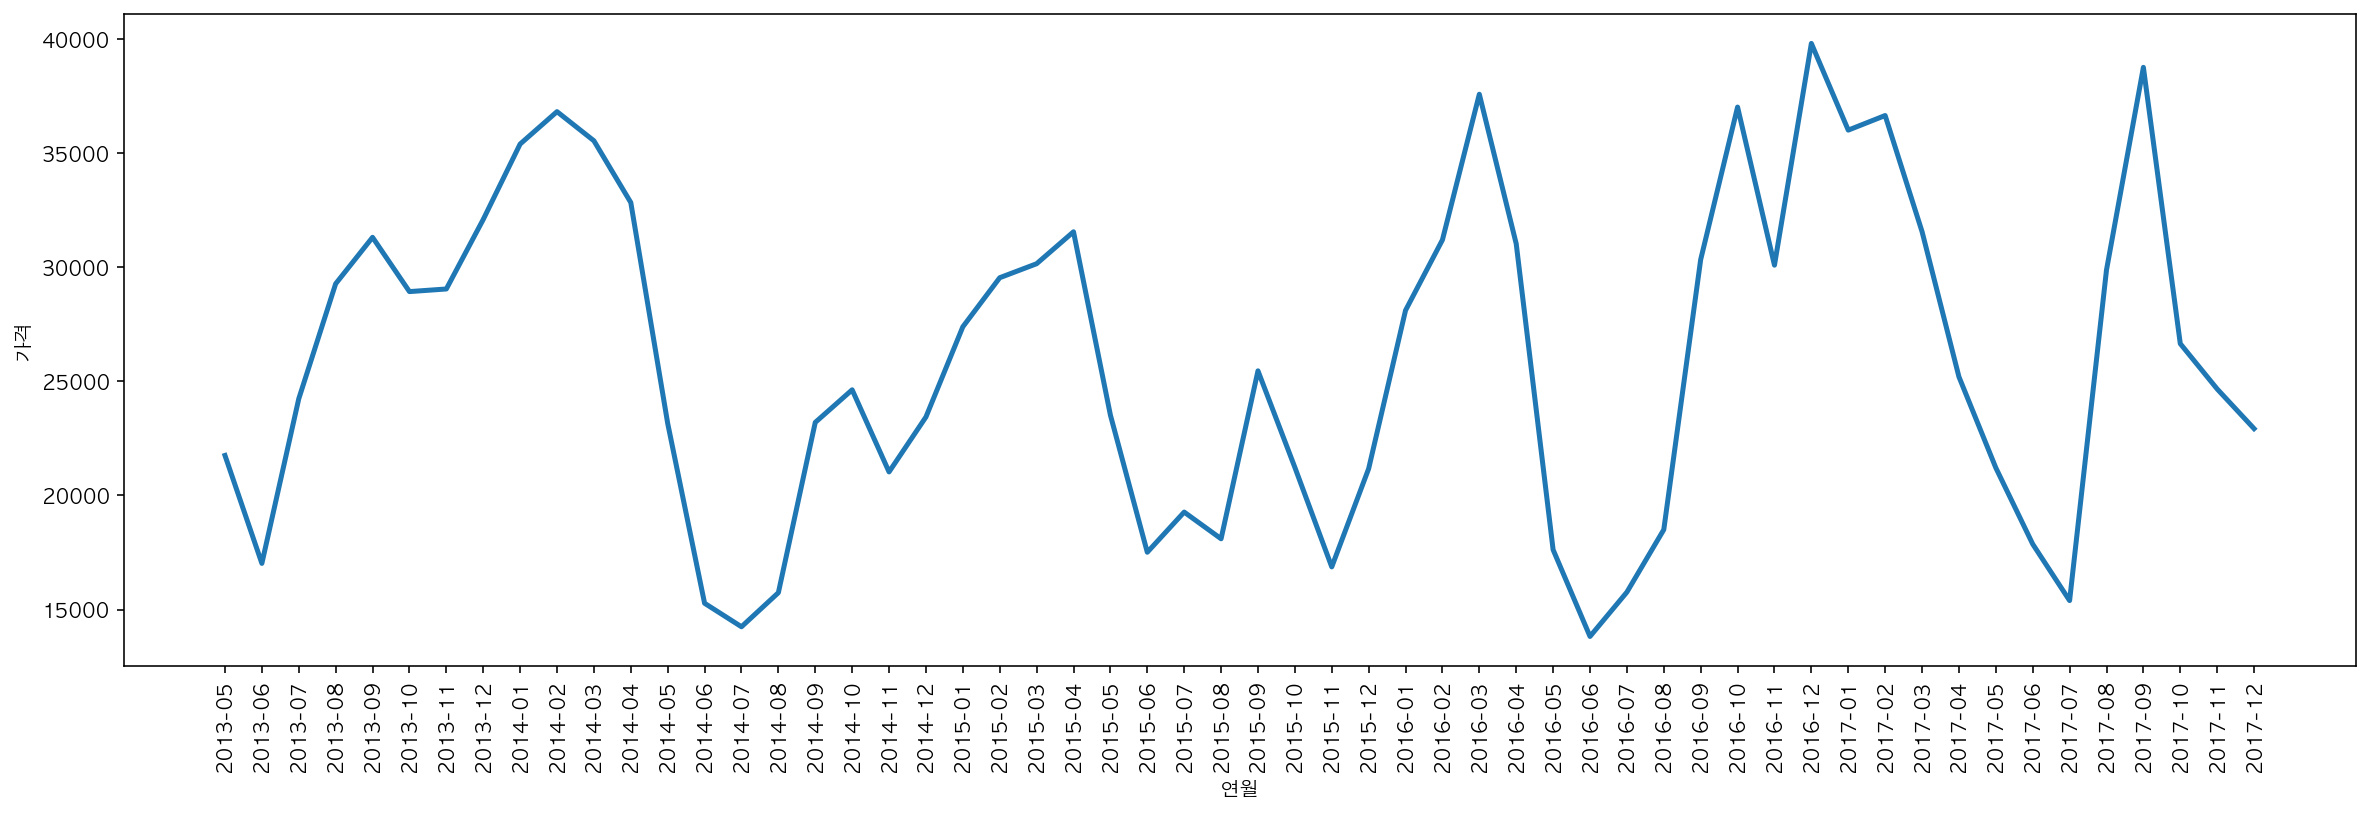

In [118]:
plt.figure(figsize=(20,6))
s = plt.xticks(rotation=90)
sns.lineplot(data=train_data, x='연월', y='가격', ci=None, linewidth=2.5)

#### 파종 시기에 따른 월 평균 토마토 도매 가격

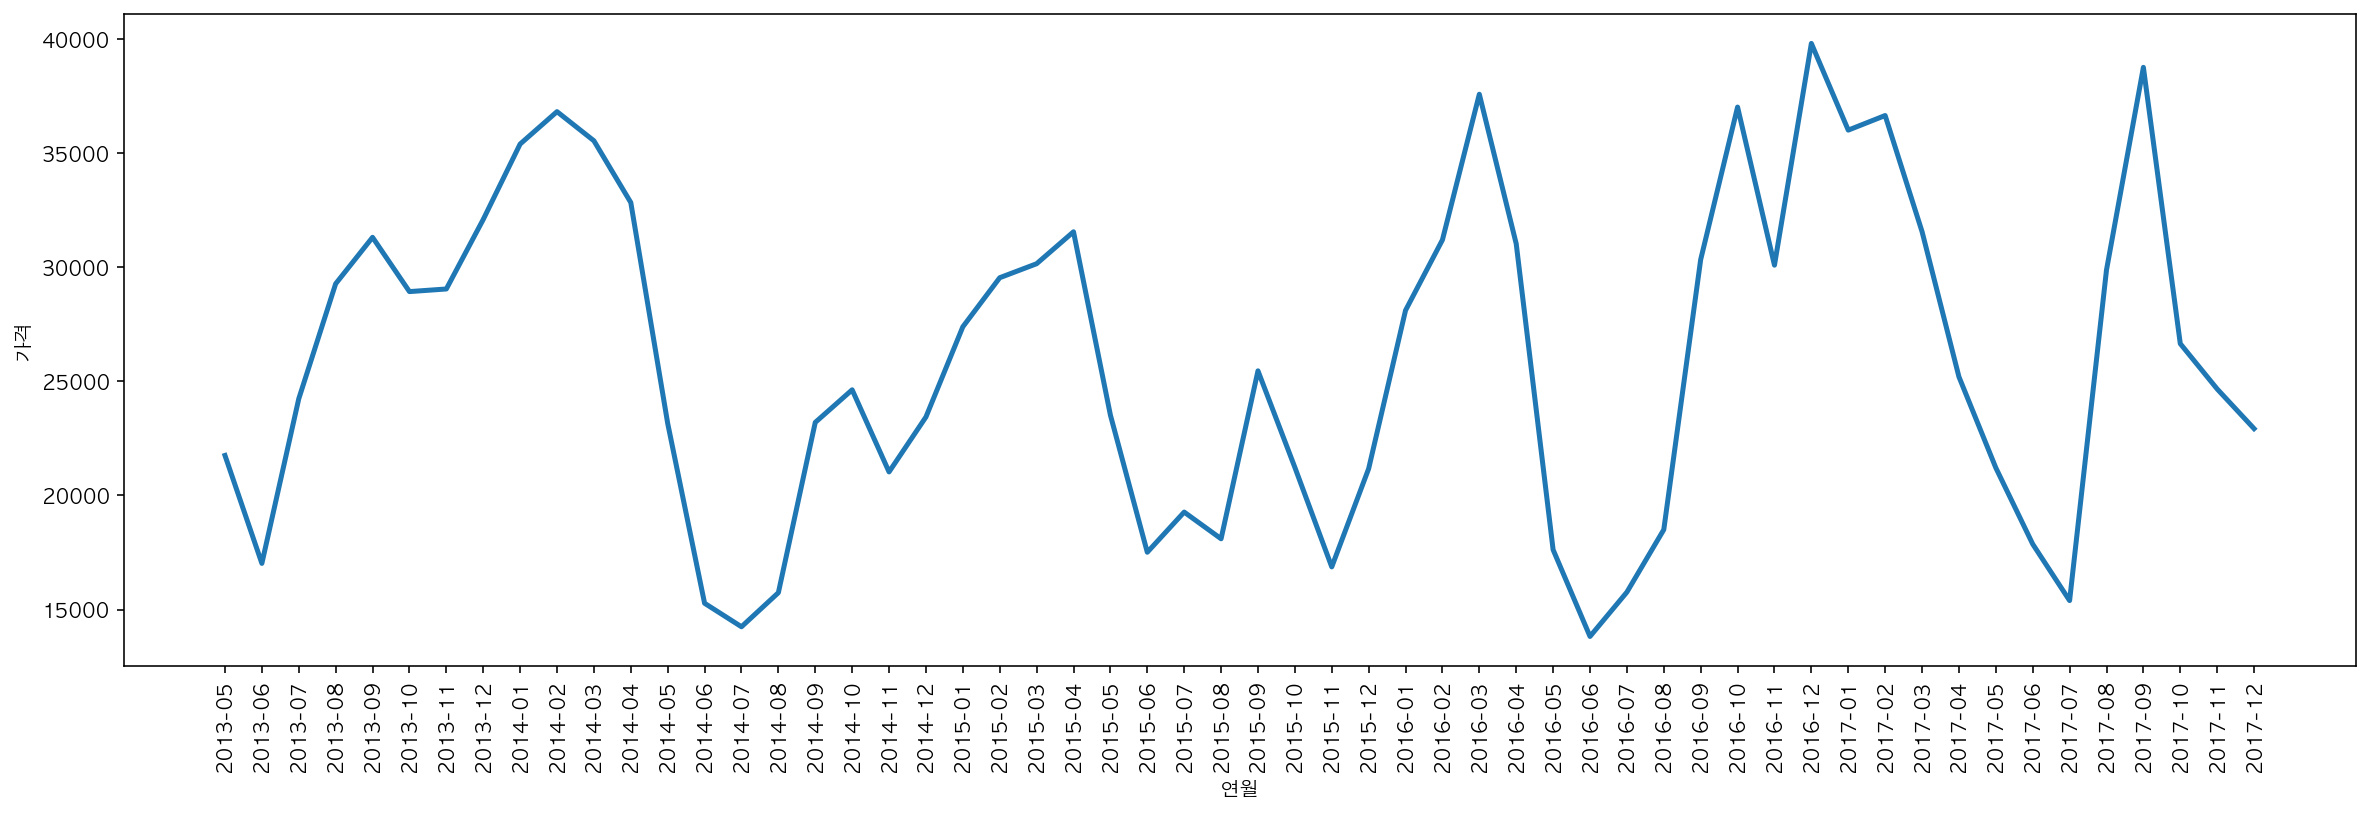

In [119]:
plt.figure(figsize=(20,6))
s = plt.xticks(rotation=90)
sns.lineplot(data=train_data, x='연월', y='가격', ci=None, linewidth=2.5)

#### 월 평균 일조량

* **봄 일조량 상승, 여름, 겨울 일조량 하락**
→ 일조량 패턴이 뚜렷한 계절성을 보이고 있음!

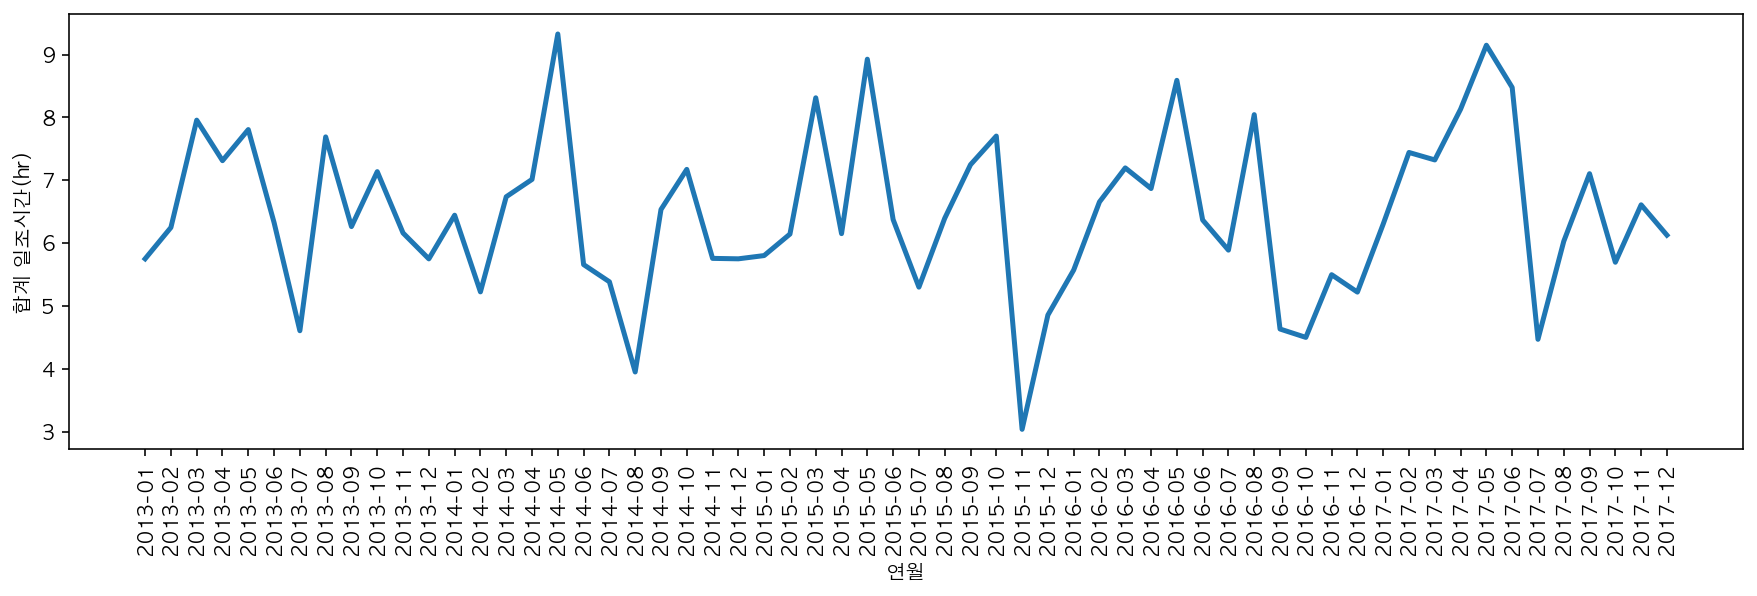

In [120]:
plt.figure(figsize=(15, 4))
plt.xticks(rotation=90)
sns.lineplot(data=train_data, x='연월', y='합계 일조시간(hr)', ci=None, linewidth=2.5)

#### 월 평균 대기오염 
* **봄, 겨울 PM10과 PM25 상승, 여름 PM10과 PM25 하락**
→ PM10과 PM25 패턴이 뚜렷한 계절성을 보이고 있음

In [121]:
ss = train_data[['연월', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']]

In [122]:
ss_1 = ss.groupby(['연월'])['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'].mean().reset_index()
ss_1

,연월,SO2,CO,O3,NO2,PM10,PM25
0,2013-01,0.007208,0.770745,0.017697,0.029585,61.436295,30.900525
1,2013-02,0.006048,0.598919,0.022497,0.024870,48.492788,28.882708
2,2013-03,0.005526,0.526044,0.029922,0.023834,61.089004,32.543501
3,2013-04,0.004825,0.469235,0.036153,0.020936,50.820526,26.171680
4,2013-05,0.005120,0.438621,0.038800,0.021190,57.012092,25.056091
5,2013-06,0.004753,0.395590,0.034327,0.018814,43.130911,24.502940
6,2013-07,0.003804,0.361361,0.025501,0.012898,35.103109,18.512949
7,2013-08,0.004129,0.389981,0.027949,0.015106,37.427338,15.773766
8,2013-09,0.003737,0.390080,0.025361,0.017223,32.068012,17.109025
9,2013-10,0.003603,0.417879,0.021400,0.020130,33.781902,19.363692


In [123]:
ss_2 = ss_1[['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']]
ss_2

,SO2,CO,O3,NO2,PM10,PM25
0,0.007208,0.770745,0.017697,0.029585,61.436295,30.900525
1,0.006048,0.598919,0.022497,0.024870,48.492788,28.882708
2,0.005526,0.526044,0.029922,0.023834,61.089004,32.543501
3,0.004825,0.469235,0.036153,0.020936,50.820526,26.171680
4,0.005120,0.438621,0.038800,0.021190,57.012092,25.056091
5,0.004753,0.395590,0.034327,0.018814,43.130911,24.502940
6,0.003804,0.361361,0.025501,0.012898,35.103109,18.512949
7,0.004129,0.389981,0.027949,0.015106,37.427338,15.773766
8,0.003737,0.390080,0.025361,0.017223,32.068012,17.109025
9,0.003603,0.417879,0.021400,0.020130,33.781902,19.363692


In [124]:
values = ss_2.values # 대기오염 수치들만 array로 변경
dates = ss_1['연월']
data = pd.DataFrame(values, index=dates, columns=['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'])

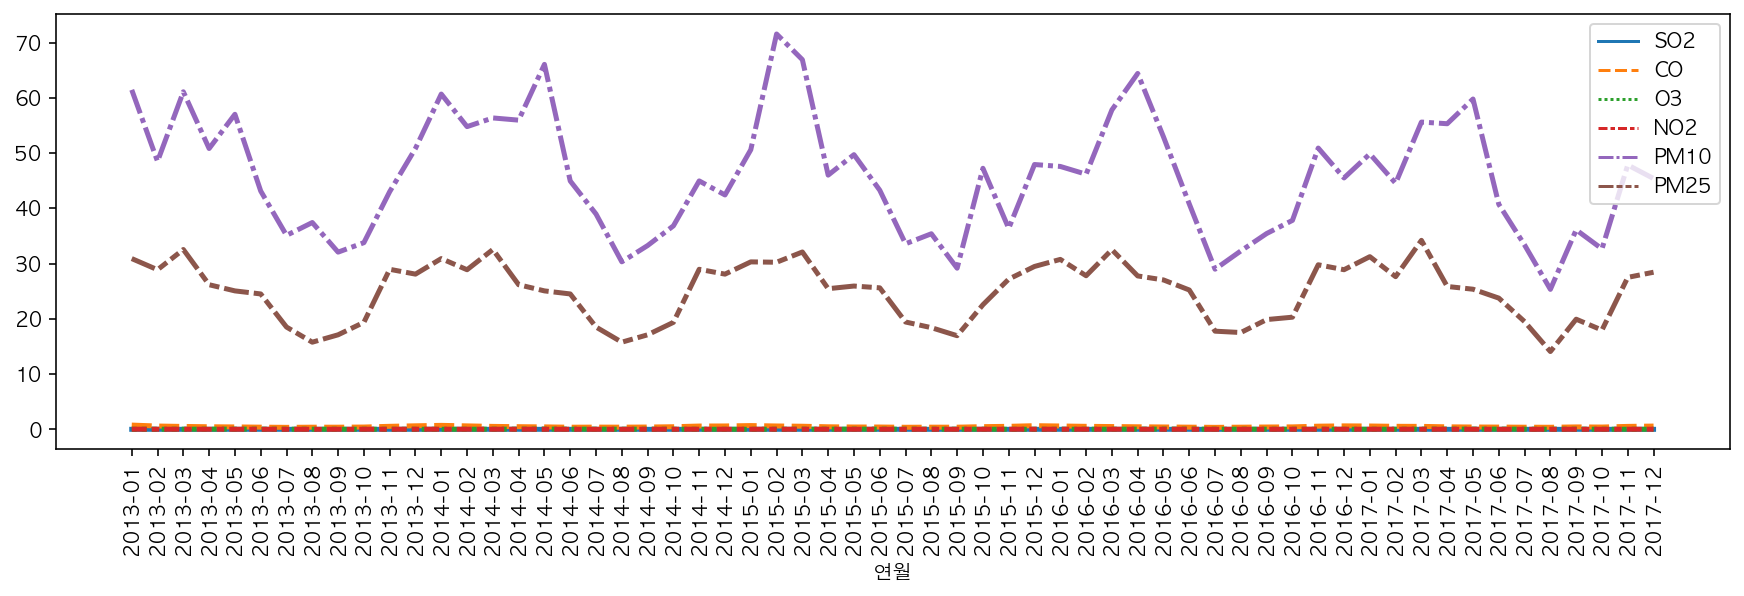

In [125]:
plt.figure(figsize=(15, 4))
plt.xticks(rotation=90)
sns.lineplot(data=data, linewidth=2.5)

#### 상관관계 분석

In [126]:
train_data.head()

,일시,도_num,연도,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr),품종명,도,마켓명,파종 예상 일시,파종 연도,가격,연월
0,2013-01-01,0,2013,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385,토마토(10kg),강원도,가락도매,NaN,NaN,NaN,2013-01
1,2013-01-01,1,2013,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000,토마토(10kg),경기도,가락도매,NaN,NaN,NaN,2013-01
2,2013-01-01,2,2013,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333,토마토(10kg),인천광역시,가락도매,NaN,NaN,NaN,2013-01
3,2013-01-01,3,2013,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000,토마토(10kg),서울특별시,가락도매,NaN,NaN,NaN,2013-01
4,2013-01-01,4,2013,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667,토마토(10kg),경상북도,북부도매,NaN,NaN,NaN,2013-01


In [127]:
# 분석에 사용할 독립변수 컬럼 따로 빼기
tom_f = train_data.iloc[:,3:10]
tom_f

,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr)
0,0.007216,0.770076,0.020583,0.018420,45.132576,31.543635,3.115385
1,0.006340,0.649199,0.013143,0.031923,44.532051,31.543635,3.800000
2,0.007477,0.713492,0.013913,0.030154,39.626984,31.543635,5.533333
3,0.005741,0.658125,0.008458,0.043541,38.334375,31.543635,4.600000
4,0.006363,0.739583,0.015653,0.017980,48.280093,31.543635,2.686667
...,...,...,...,...,...,...,...
27385,0.003583,0.700260,0.028560,0.017779,69.770833,34.403416,8.800000
27386,0.003392,0.557803,0.029622,0.013610,71.634133,31.628244,7.985714
27387,0.002731,0.600926,0.027796,0.016380,79.917069,31.310185,6.100000
27388,0.003782,0.399265,0.028774,0.014218,78.670238,38.210317,8.900000


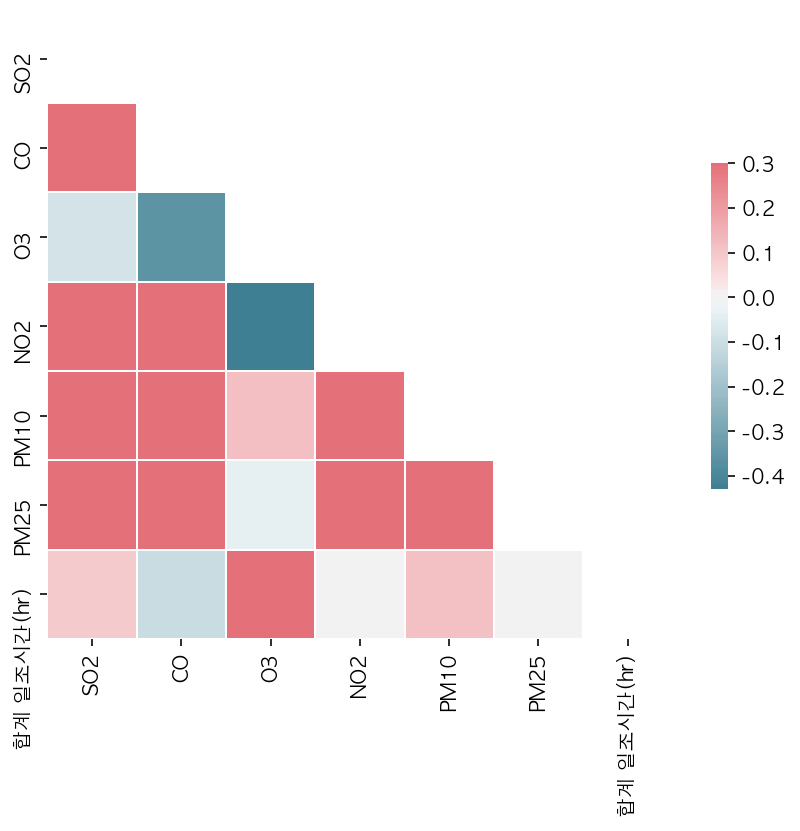

In [128]:
# 변수끼리의 상관관계 계산
corr = tom_f.corr()

# 삼각 행렬 모양으로 만들기
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# 컬러맵 지정
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# 상관관계 계수를 히트맵 그래프로 나타낸다.
plt.figure(figsize=(7,6))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 4. 다양한 머신러닝 시도

### 1) 변수 선택: PCA(주성분 분석) 


In [129]:
from sklearn.preprocessing import StandardScaler # 데이터 표준화 위해 설치
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA # PCA 하기 위해 설치

In [130]:
# 데이터의 스케일을 맞추기 위해 표준화 한다.
tomato_std = StandardScaler().fit_transform(tom_f)
# tomato_std = Normalizer().fit_transform(tom_f)

tomato_std = pd.DataFrame(tomato_std)
tomato_std.columns= ['SO2','CO','O3','NO2','PM10','PM25','합계 일조시간(hr)']
tomato_std

,SO2,CO,O3,NO2,PM10,PM25,합계 일조시간(hr)
0,1.297766,1.624683,-0.602105,-0.234635,-0.024019,0.727145,-0.883299
1,0.868943,0.917759,-1.221802,1.096793,-0.049325,0.727145,-0.703041
2,1.425758,1.293765,-1.157707,0.922361,-0.256019,0.727145,-0.246658
3,0.575192,0.969962,-1.612004,2.242284,-0.310489,0.727145,-0.492403
4,0.880083,1.446355,-1.012774,-0.278056,0.108614,0.727145,-0.996180
...,...,...,...,...,...,...,...
27385,-0.481691,1.216382,0.062268,-0.297919,1.014212,1.040605,0.613449
27386,-0.575264,0.383249,0.150704,-0.708992,1.092729,0.736419,0.399049
27387,-0.899023,0.635445,-0.001333,-0.435809,1.441764,0.701557,-0.097456
27388,-0.384429,-0.543930,0.080085,-0.648984,1.389224,1.457877,0.639779


In [131]:
# 공분산 행렬 구하기
tom_cov = np.cov(tomato_std.T)
tom_cov

array([[ 1.00003651,  0.51971794, -0.08212576,  0.51969242,  0.43148246,
         0.30450038,  0.09457477],
       [ 0.51971794,  1.00003651, -0.35795093,  0.67097896,  0.55477136,
         0.500115  , -0.10751782],
       [-0.08212576, -0.35795093,  1.00003651, -0.43031651,  0.11837831,
        -0.034791  ,  0.36520248],
       [ 0.51969242,  0.67097896, -0.43031651,  1.00003651,  0.43828669,
         0.3717405 , -0.00231155],
       [ 0.43148246,  0.55477136,  0.11837831,  0.43828669,  1.00003651,
         0.53796655,  0.11594298],
       [ 0.30450038,  0.500115  , -0.034791  ,  0.3717405 ,  0.53796655,
         1.00003651,  0.01466716],
       [ 0.09457477, -0.10751782,  0.36520248, -0.00231155,  0.11594298,
         0.01466716,  1.00003651]])

In [132]:
# 고유값과 고유벡터 계산 (고유분해)
eig_vals, eig_vecs= np.linalg.eig(tom_cov)

# 고유값 확인
eig_vals

array([3.02565344, 1.51882335, 0.84697116, 0.60950099, 0.43806389,
       0.26976279, 0.29147996])

In [133]:
# 고유벡터 확인
eig_vecs

array([[-0.40429172, -0.12982074,  0.37027522, -0.64825982,  0.4674034 ,
         0.19932956,  0.06443629],
       [-0.50418616,  0.11061459, -0.02352074,  0.02214889, -0.19112898,
        -0.58040094,  0.59926738],
       [ 0.19101636, -0.66620905, -0.23116876, -0.35332422, -0.06857245,
        -0.52643305, -0.24406418],
       [-0.47230728,  0.15124836,  0.32377465,  0.15636089, -0.20046771,
        -0.24857513, -0.72304503],
       [-0.41676413, -0.33781918, -0.29200787, -0.09286493, -0.58136944,
         0.52857438,  0.03020047],
       [-0.38578211, -0.18369401, -0.52819391,  0.40566305,  0.60087418,
         0.02509565, -0.11044361],
       [ 0.01621501, -0.59693814,  0.58293792,  0.50674993,  0.03277328,
         0.0667866 ,  0.20311396]])

In [134]:
# 주성분의 고유값 비율 확인
eig_vals_sum = np.sum(eig_vals)
for eig_val in eig_vals:
    print (str(eig_val/eig_vals_sum))

0.4322204248822301
0.2169668432177172
0.1209914619425564
0.0870683908342937
0.0625782704215688
0.03853613491381767
0.04163847378781622


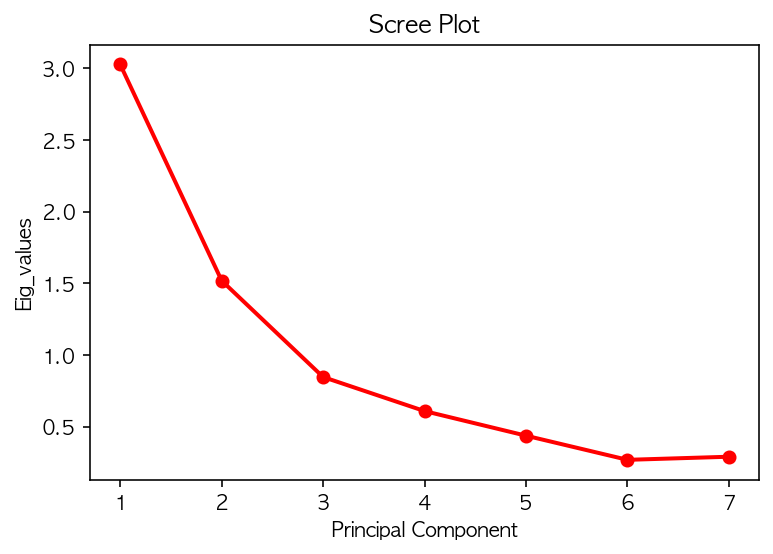

In [135]:
# 위 데이터를 이용해 scree plot 그려서 고유값 확인. 주성분 개수를 정할 때 한 눈에 볼 수 있어서 좋다.
sing_vals = np.arange(len(eig_vals))+1
plt.plot(sing_vals, eig_vals, "ro-", linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eig_values")
plt.show()

In [136]:
# 주성분의 개수를 4개로 하여 주성분 분석
pca = PCA(n_components = 4)
pca

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [137]:
# 각 주성분 데이터들을 찾아서 array로 만든다.
pca_values = pca.fit_transform(tomato_std)
pca_values

array([[ 1.63284284, -0.77869333,  0.38643263,  0.77965908],
       [ 1.83679762, -1.27133696, -0.15821799, -0.00350474],
       [ 2.06331896, -0.96895213, -0.61065509,  0.14858166],
       ...,
       [ 0.62443747,  0.43577851,  1.33700301, -0.63052329],
       [ 0.37954703,  1.28078903,  1.16094323, -0.8939956 ],
       [ 0.16939579,  0.51176733,  1.09986434, -0.04657205]])

In [138]:
# 고유값의 누적 설명력 확인. 80% 넘는것을 확인할 수 있다.
sum(pca.explained_variance_ratio_)

0.8572471208767976

In [139]:
# 위에서 구한 주성분으로 이루어진 데이터 프레임 생성
pcadf = pd.DataFrame(data=pca_values, columns = ['PC1', 'PC2','PC3','PC4'])
pcadf

,PC1,PC2,PC3,PC4
0,1.632843,-0.778693,0.386433,0.779659
1,1.836798,-1.271337,-0.158218,-0.003505
2,2.063319,-0.968952,-0.610655,0.148582
3,2.247657,-1.710944,-0.708356,-0.643060
4,1.489110,-1.102792,0.560553,0.444051
...,...,...,...,...
27385,1.080123,0.789424,0.806017,-0.909434
27386,0.330043,0.833188,0.961849,-0.616783
27387,0.624437,0.435779,1.337003,-0.630523
27388,0.379547,1.280789,1.160943,-0.893996


In [140]:
t1 = train_data.iloc[:,0:3]
t2 = train_data.iloc[:, -4:]

In [141]:
# 데이터 병합 후 확인
tom_fin = pd.concat([t1, pcadf ,t2], axis=1)
tom_fin

,일시,도_num,연도,PC1,PC2,PC3,PC4,파종 예상 일시,파종 연도,가격,연월
0,2013-01-01,0,2013,1.632843,-0.778693,0.386433,0.779659,NaN,NaN,NaN,2013-01
1,2013-01-01,1,2013,1.836798,-1.271337,-0.158218,-0.003505,NaN,NaN,NaN,2013-01
2,2013-01-01,2,2013,2.063319,-0.968952,-0.610655,0.148582,NaN,NaN,NaN,2013-01
3,2013-01-01,3,2013,2.247657,-1.710944,-0.708356,-0.643060,NaN,NaN,NaN,2013-01
4,2013-01-01,4,2013,1.489110,-1.102792,0.560553,0.444051,NaN,NaN,NaN,2013-01
...,...,...,...,...,...,...,...,...,...,...,...
27385,2017-12-31,10,2017,1.080123,0.789424,0.806017,-0.909434,NaN,NaN,NaN,2017-12
27386,2017-12-31,11,2017,0.330043,0.833188,0.961849,-0.616783,NaN,NaN,NaN,2017-12
27387,2017-12-31,12,2017,0.624437,0.435779,1.337003,-0.630523,NaN,NaN,NaN,2017-12
27388,2017-12-31,13,2017,0.379547,1.280789,1.160943,-0.893996,NaN,NaN,NaN,2017-12


In [142]:
# 데이터 저장
# tom_fin.to_csv('tom1317_fin.csv',encoding = 'cp949', index=False)

In [143]:
# 저장된 데이터 확인
# pd.read_csv('tom1317_fin.csv', encoding = 'cp949')

### 3) 머신러닝 적용

#### 필요한 라이브러리 불러오기

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import import_ipynb
from functions import date_time, factorize, data_preparation

importing Jupyter notebook from functions.ipynb


#### 머신러닝 전처리

In [152]:
df = pd.read_csv('tom1317_fin.csv',encoding='cp949')
df_2 = pd.read_csv('tom18_fin.csv',encoding='cp949')

In [153]:
data_preparation(df)
data_preparation(df_2)

,일시,도_num,연도,PC1,PC2,PC3,PC4,품종명,도,마켓명,가격,월,일,마켓명_num
0,2018-01-01,0,2018,-2736.999846,-0.287189,-0.596709,-0.637110,토마토(10kg),강원도,가락도매,20000.0,1,1,0
1,2018-01-01,1,2018,-2735.999866,1.109665,-1.277604,-1.747242,토마토(10kg),경기도,가락도매,20000.0,1,1,0
2,2018-01-01,2,2018,-2734.999867,0.796281,-1.333817,-1.825225,토마토(10kg),인천광역시,가락도매,20000.0,1,1,0
3,2018-01-01,3,2018,-2733.999849,1.376341,-1.524232,-2.024307,토마토(10kg),서울특별시,가락도매,20000.0,1,1,0
4,2018-01-01,4,2018,-2732.999954,-0.320868,-0.171794,-0.214173,토마토(10kg),경상북도,북부도매,25000.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,2018-12-31,10,2018,2733.000299,-0.282314,-0.577534,-0.691436,토마토(10kg),울산광역시,엄궁도매,30000.0,12,31,4
5471,2018-12-31,11,2018,2734.000183,0.224926,-0.486470,-0.235151,토마토(10kg),경상남도,엄궁도매,30000.0,12,31,4
5472,2018-12-31,12,2018,2735.000073,1.072092,-0.097974,-0.955989,토마토(10kg),광주광역시,각화도매,31000.0,12,31,3
5473,2018-12-31,13,2018,2736.000264,0.060489,-0.728764,-0.665153,토마토(10kg),부산광역시,엄궁도매,30000.0,12,31,4


In [154]:
df_label = df['가격']
df = df.drop(['품종명','도','일시','마켓명','가격'],axis=1)

In [155]:
df_2_label = df_2['가격']
df_2 = df_2.drop(['품종명','도','일시','마켓명','가격'],axis=1)

In [156]:
X_train,X_valid,y_train, y_valid = train_test_split(df, df_label, test_size = 0.3, random_state = 234)

#### XG boost

In [ ]:
# xgboost grid search
xgb= XGBRFRegressor(silent=True,n_jobs=-1,n_estimators=1000)

In [ ]:
params = {'learning_rate' : [0.01,0.03,0.05],
        'min_child_weight': [1,3],
        'gamma': [0.5, 1, 1.5,],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgb_ran = GridSearchCV(xgb,param_grid=params,scoring='neg_mean_squared_error',
                       n_jobs=-1,cv=skf.split(X_train,y_train),verbose=3)
xgb_ran.fit(X_train,y_train)

In [ ]:
np.sqrt(-xgb_ran.best_score_)

#### Random Forest

In [ ]:
n_estimators = [int(x) for x in np.linspace(start= 700, stop = 1500, num=8)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(1,5, num=4)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

In [ ]:
grid_search = {'n_estimators': n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf
              }

numFolds = 3
skf =StratifiedKFold(shuffle = True, n_splits = numFolds,random_state=42)

rf = RandomForestRegressor()

clf = GridSearchCV(rf,
                    param_grid= grid_search,
                    cv = skf.split(X_train,y_train),
                    scoring='neg_mean_squared_error',
                    verbose=3,
                    n_jobs = - 1)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
np.sqrt(-clf.best_score_)

#### 선형회귀

In [ ]:
mlr = LinearRegression(n_jobs=-1)
mlr.fit(X_train,y_train)

In [ ]:
predicted = mlr.predict(X_valid)

In [ ]:
a = plt.scatter(y_valid,predicted,alpha=0.4)
plt.savefig('scatter.png')

In [ ]:
mlr.score(X_train,y_train)

#### Decision Tree

In [ ]:
regressor = DecisionTreeRegressor(random_state=42,min_samples_leaf=5,max_features= 8)

In [ ]:
regressor.fit(X_train,y_train)

In [ ]:
mean_squared_error(regressor.predict(df_2),df_2_label)

#### ARIMA

In [ ]:
from datetime import date, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [ ]:
tm = pd.read_csv('full_data_ver2.csv')
tm

In [ ]:
tm.info()

In [ ]:
tm1 = tm.groupby(['일시']).mean()
tm1 = tm1.reset_index()
tm1

In [ ]:
tm1['연월'] = tm1['일시'].str.split("-").str.get(0) + '-' + tm1['일시'].str.split("-").str.get(1)
tm1

In [ ]:
tm2 = tm1.groupby(['연월'])['가격'].mean()
tm2 = pd.DataFrame(tm2)
tm2 = tm2.reset_index()
tm2

In [ ]:
decomposition = seasonal_decompose(pd.to_datetime(tm2['연월']), freq=12)  
fig = plt.figure()  
fig = decomposition.plot()

In [ ]:
def test_stationarity(tm2):

    #Determing rolling statistics
    rolmean = tm2.rolling(12).mean()
    rolstd = tm2.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(tm2, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(tm2, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(tm2['가격'])

In [ ]:
tm2['first_difference'] = tm2['가격'] - tm2['가격'].shift(1)  
# Or Alternatively,
# df.diff().plot()
test_stationarity(tm2.first_difference.dropna(inplace=False))

In [ ]:
tm2['seasonal_first_difference'] = tm2['first_difference'] - tm2['first_difference'].shift(12)  
test_stationarity(tm2.seasonal_first_difference.dropna(inplace=False))

In [ ]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tm2.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tm2.seasonal_first_difference.iloc[13:],lags=40,ax=ax2)

In [ ]:
mod = sm.tsa.SARIMAX(tm2['가격'], trend='ct',order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

In [ ]:
tm2['forecast'] = results.predict(start = len(tm2)-12, end= len(tm2), dynamic= True)  
tm2[['가격', 'forecast']].plot()
# tm2[-12:]

#### VAR 모형

In [ ]:
# VAR 모형 돌리기 위해 필요한 패키지 설치
from statsmodels.tsa.vector_ar.var_model import VARProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

In [ ]:
# 서울특별시 13-17년 데이터 잘라서 모형에 쓰기
seoul = pd.read_csv('도_분할/서울특별시.csv')
seoul1317 = seoul[seoul['일시'].str.contains('2013|2014|2015|2016|2017')]
seoul1317.plot()
plt.show()

In [ ]:
seoul1317.head(20)

In [ ]:
m2 = sm.tsa.VAR(seoul1317[['SO2','CO','O3','NO2','PM10','PM25','합계 일조시간(hr)','가격']])
r = m2.fit()
print(r.summary())

In [ ]:
fig = r.plot_forecast(steps=100, alpha=0.05, plot_stderr=True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05,1.05), scatterpoints=1 )
plt.show()

In [ ]:
irf = r.irf(10)

In [ ]:
plt.figure(figsize=(25,25))
irf.plot()
plt.tight_layout()
plt.show()

#### keras를 사용한 회귀 분석

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('일별그룹_data.csv')

In [ ]:
df.columns

In [ ]:
df['일시'] = df['일시'].str.replace('-', '')

In [ ]:
df = df[['일시', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', '합계 일조시간(hr)', '가격']]
df

In [ ]:
train_dataset = df[~df['일시'].str.contains('2018')]
test_dataset = df[df['일시'].str.contains('2018')]

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("가격")

In [ ]:
train_stats = train_stats.transpose()
train_stats

In [ ]:
train_labels = train_dataset.pop('가격')
test_labels = test_dataset.pop('가격')

In [ ]:
train_dataset1 = train_dataset.set_index('일시')
test_dataset1 = test_dataset.set_index('일시')

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset1)
normed_test_data = norm(test_dataset1)

In [ ]:
train_dataset.keys()

In [ ]:
len(train_dataset.keys())

In [ ]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [ ]:
model = build_model()
model.summary()

In [ ]:
example_batch = normed_train_data
example_result = model.predict(example_batch)
example_result

In [ ]:
mean_squared_error(example_result,train_labels)

In [ ]:
normed_test_data

In [ ]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [가격]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$가격^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} 가격".format(mae))

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [가격]')
plt.ylabel('Predictions [가격]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

## 5. 결론

### 1) 결과 문제 파악

* 데이터 전처리
    - 2013년 ~ 2014년 PM25 NaN : 패턴을 고려해서 넣지 않음
    - 마켓이 열리지 않는 일자 : 가격을 예측하기 위함이기 때문에 가격을 채워 넣어선 안됨

* 피처 엔지니어링
    - PCA 외 고민이 없음

* 머신러닝 학습 데이터 
    - 일조량에 영향을 받은 토마토 재배 기간을 고려하지 않음


### 2) 개선 방향

* 데이터 전처리
    - 2013년 ~ 2014년 PM25 NaN : 패턴을 고려하여 NaN 채움
    - 마켓이 열리지 않는 일자 : 휴일 주기가 같다면 이상치 처리

* 피처 엔지니어링
    - 피처 맵핑 시도
    - 해가 땅에 닿는데 방해하는 수치 컬럼 추가
    - 컬럼마다 모두 그래프를 그려 추세, 이상치 파악

* 머신러닝 학습 데이터 
    - 재배 기간을 고려하여 학습 데이터 전처리